In [1]:
import time

import numpy as np
import math
import cmath
import os
import unittest
import random
import gmpy2
import util.random_sample

from scipy.stats import bernoulli
from ckks.ckks_decryptor import CKKSDecryptor
from ckks.ckks_encoder import CKKSEncoder
from ckks.ckks_encryptor import CKKSEncryptor
from ckks.ckks_evaluator import CKKSEvaluator
from ckks.ckks_key_generator import CKKSKeyGenerator
from ckks.ckks_parameters import CKKSParameters
from gmpy2 import mpfr
from numpy import random

import util.matrix_operations as mat
from tests.helper import check_complex_vector_approx_eq
from util.plaintext import Plaintext
from util.random_sample import sample_random_complex_vector
from util.ciphertext import Ciphertext
from util.public_key import PublicKey

from pymobility.models.mobility import gauss_markov

from space_time_lord import *
from gov_agent import *
from mob_operator import *
from user import *

import pandas as pd

import seaborn as sns

sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family": 'sans', "font.size": 24, "axes.titlesize": 24, "axes.labelsize": 24})
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TICK_COUNT = 100

POPSIZE = 500  #7.5k/km**2 total, 5k/km**2 smartphone
TOTAL_AREA_SIZES = (200, 200)
AREA_SIDES = (50, 50)

RISK_THRESHOLD = 10
MO_COUNT = 2
CONTACT_TUPLES = [(1, 14), (2, 12), (3, 11), (4, 10), (5, 9), (6, 9), (7, 9), (8, 8), (9, 7), (10, 7)]

INFECTED_COUNT = 50

In [3]:
class DualIter:

    def __init__(self, init_iter):
        self._iterator = init_iter
        self._change = True
        self._next_val = None

    def __next__(self):
        if self._change:
            self._next_val = next(self._iterator)
        self._change = not self._change

        return self._next_val.copy()


class MinutelyMovement:
    def __init__(self, movement_iter):
        self._move = movement_iter

    def __next__(self):
        for i in range(60):
            self_next = next(self._move)

        return self_next

In [4]:
movements_iter = gauss_markov(nr_nodes=POPSIZE,
                              dimensions=TOTAL_AREA_SIZES,
                              alpha=.5,
                              velocity_mean=7,
                              variance=7)

minutely_gm = MinutelyMovement(movements_iter)

dual_gm = DualIter(minutely_gm)

plain_stl = SpaceTimeLord(movements_iterable=dual_gm,
                          mo_count=MO_COUNT,
                          risk_thr=RISK_THRESHOLD,
                          area_sizes=AREA_SIDES,
                          max_sizes=TOTAL_AREA_SIZES)

simple_stl = SimpleSTL(movements_iterable=dual_gm,
                       mo_count=MO_COUNT,
                       risk_thr=RISK_THRESHOLD,
                       area_sizes=AREA_SIDES,
                       max_sizes=TOTAL_AREA_SIZES)

infected_vect = util.random_sample.sample_hamming_weight_vector(length=POPSIZE,
                                                            hamming_weight=INFECTED_COUNT)
infected_vect = list(map(abs, infected_vect))

plain_stl._ga._status = infected_vect
simple_stl._ga._status = infected_vect.copy()

for i in range(TICK_COUNT):
    plain_stl.tick()
    simple_stl.tick()

In [5]:
scores_df = pd.DataFrame(columns=['simple', 'curve'])
for i in range(plain_stl.user_count):
    plain_stl.users[i].ping_mo_for_score()
    simple_stl.users[i].ping_mo_for_score()
    scores_df = scores_df.append({'simple': simple_stl.users[i]._score,
                                  'curve': plain_stl.users[i]._score}, ignore_index=True)

/tmp/ipykernel_3403/3006111279.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'simple': simple_stl.users[i]._score,
/tmp/ipykernel_3403/3006111279.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'simple': simple_stl.users[i]._score,
/tmp/ipykernel_3403/3006111279.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'simple': simple_stl.users[i]._score,
/tmp/ipykernel_3403/3006111279.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'simple': simple_stl.users[i]._score,
/tmp/ipykernel_3403/3006111279.py:5: Fut

In [6]:
scores_df.describe()

,simple,curve
count,500.0,500.000000
unique,8.0,500.000000
top,2.0,0.459988
freq,138.0,1.000000


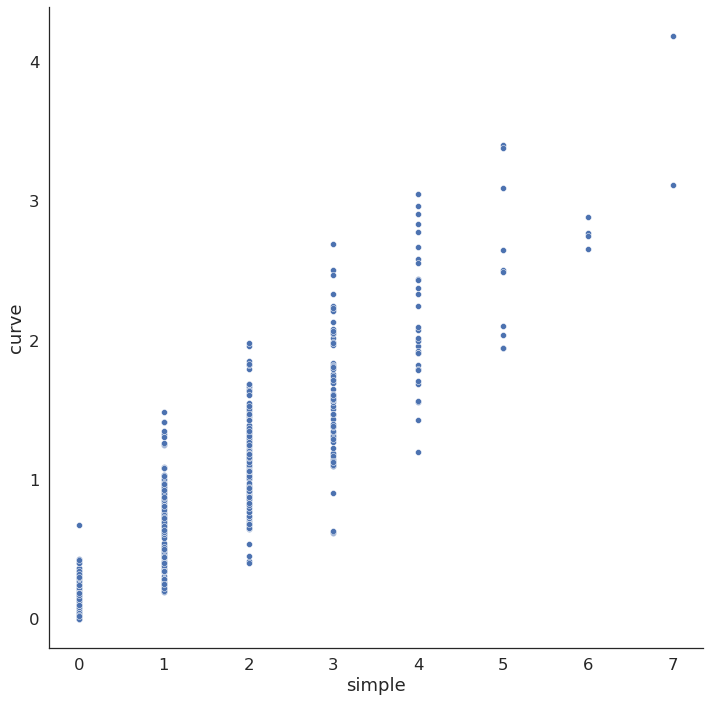

In [7]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.pairplot(scores_df, x_vars=["simple"], y_vars=["curve"], height=10).add_legend()
plt.grid(False)

In [8]:
simple_score_set = set(scores_df['simple'])

In [9]:
curve_mean = []
for val in simple_score_set:
    john=scores_df[scores_df['simple'] == val]
    curve_mean.append((val, john['curve'].mean()))
print(curve_mean)

[(0.0, 0.17243102165840954), (1.0, 0.6685754014986636), (2.0, 1.1316326708725524), (3.0, 1.5816281986422454), (4.0, 2.1497867981948158), (5.0, 2.556850483665552), (6.0, 2.765896913895812), (7.0, 3.648910580101761)]


In [10]:
for tuple in curve_mean:
    print(str(tuple[0]) + " " + str(tuple[1]))

0.0 0.17243102165840954
1.0 0.6685754014986636
2.0 1.1316326708725524
3.0 1.5816281986422454
4.0 2.1497867981948158
5.0 2.556850483665552
6.0 2.765896913895812
7.0 3.648910580101761
